In [1]:
try:

    import sys
    from sys import exit
    import os
    import numpy as np
    np.random.seed(42) # to make this notebook's output stable across runs
    import pandas as pd
    import matplotlib as mpl
    mpl.rc('axes', labelsize=14)
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', labelsize=12)
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    import datetime
    import tables 
    plt.style.use('seaborn')
    
    import _utility_functions_ML as ufML
        
    cwd = os.getcwd()
    sys.path.append('..\\..\\source_system')
    from indicators import *
    import visualizer as viz
    import utility_functions as uf
    sys.path.remove('..\\..\\source_system')
    os.chdir(cwd)
    
    import random
    import statistics
    import pickle
    from statistics import mean
    import operator
    import sklearn
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import StratifiedShuffleSplit # Example on p55 on Geron
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
    from sklearn.model_selection import GridSearchCV
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler    

except Exception as e:
    
    print(e)
    

In [2]:
account_type = 'backtest'
symbol = 'EUR_USD'
start_datetime = datetime.datetime(2020,1,1,0,0,0)
end_datetime = datetime.datetime(2021,1,1,0,0,0)


In [3]:
# Read data
input_data_foldername = os.path.join( '..\\..\\..\\datastore', '_{}'.format(account_type), '{}'.format(symbol) )

data_granularity = '1H'
input_data_filename = '{}.hdf'.format(data_granularity)

df = pd.DataFrame()            
df = uf.read_hdf_to_df(input_data_foldername, input_data_filename)

df = df.loc[(df.index >= start_datetime) & (df.index <= end_datetime), :]
            
df.head()

Reading dataframe from ..\..\..\datastore\_backtest\EUR_USD\1H.hdf


,ask_o,ask_h,ask_l,ask_c,bid_o,bid_h,bid_l,bid_c,volume
date,,,,,,,,,
2020-01-01 22:00:00,1.12158,1.12210,1.12158,1.12171,1.12084,1.12141,1.12075,1.12132,65
2020-01-01 23:00:00,1.12164,1.12258,1.12164,1.12196,1.12134,1.12210,1.12134,1.12183,462
2020-01-02 00:00:00,1.12198,1.12199,1.12164,1.12191,1.12184,1.12186,1.12151,1.12178,451
2020-01-02 01:00:00,1.12190,1.12253,1.12187,1.12217,1.12177,1.12239,1.12175,1.12203,912
2020-01-02 02:00:00,1.12216,1.12254,1.12191,1.12230,1.12202,1.12240,1.12178,1.12217,603


In [4]:
# Use only bid data, eliminate ask data
df.drop(['ask_o', 'ask_h', 'ask_l', 'ask_c'], axis=1, inplace=True)

cols = []
cols = list(df.columns.values)

for lag in range(1,13):
    df['log_return_{}'.format(lag)] = np.log( df['bid_c'] / df['bid_c'].shift(lag) ) 
        
df.dropna(inplace=True)

def f(row,lag):
    if row['log_return_{}'.format(lag)] >= 0.0:
        val = 1
    else:
        val = 0
    return val

for lag in range(1,13):
    df['Up_{}'.format(lag)] = df.apply(f, args=(lag,), axis=1)
    cols.append('Up_{}'.format(lag))
    
# Note that the "Up_{}" column can be calculated more phytonic as below but this creates 0 entries so I wrote the function above.
# df['Up_{}'.format(lag)] = np.sign( df['log_return_{}'.format(lag)] ) 

def f_y(row, lag):
    if row['log_return_y_{}'.format(lag)] >= 0.0:
        val = 1
    else:
        val = 0
    return val

for lag in range(1,6):
    df['log_return_y_{}'.format(lag)] = np.log( df['bid_c'].shift(-lag) / df['bid_c'] ) 
    df['Up_y_{}'.format(lag)] = df.apply(f_y, args=(lag,), axis=1)
    
df.tail()

,bid_o,bid_h,bid_l,bid_c,volume,log_return_1,log_return_2,log_return_3,log_return_4,log_return_5,...,log_return_y_1,Up_y_1,log_return_y_2,Up_y_2,log_return_y_3,Up_y_3,log_return_y_4,Up_y_4,log_return_y_5,Up_y_5
date,,,,,,,,,,,,,,,,,,,,,
2020-12-27 22:00:00,1.21842,1.21873,1.21842,1.21850,40,0.000181,0.000172,0.000460,0.000419,0.000213,...,0.001493,1,0.000550,1,0.001583,1,0.002082,1,NaN,0
2020-12-27 23:00:00,1.21845,1.22063,1.21832,1.22032,1148,0.001493,0.001673,0.001665,0.001952,0.001911,...,-0.000943,0,0.000090,1,0.000590,1,NaN,0,NaN,0
2020-12-28 00:00:00,1.22034,1.22074,1.21803,1.21917,2999,-0.000943,0.000550,0.000730,0.000722,0.001009,...,0.001033,1,0.001533,1,NaN,0,NaN,0,NaN,0
2020-12-28 01:00:00,1.21918,1.22058,1.21902,1.22043,2345,0.001033,0.000090,0.001583,0.001763,0.001755,...,0.000500,1,NaN,0,NaN,0,NaN,0,NaN,0
2020-12-28 02:00:00,1.22044,1.22131,1.22037,1.22104,960,0.000500,0.001533,0.000590,0.002082,0.002263,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0


In [5]:
# Add_indicators

df, cols = AddWave(df, cols, 'bid', 34)
df, cols = AddWaveAngle(df, cols, 3)
df, cols = AddMACD(df, cols, 'bid', fastperiod=12, slowperiod=26, signalperiod=9)
df, cols = AddSlowStochastic(df, cols, 'bid', fastk_period=14, slowk_period=3, slowd_period=3)

df.dropna(inplace=True)

df.tail()
#df.to_excel('aaa.xlsx')

,bid_o,bid_h,bid_l,bid_c,volume,log_return_1,log_return_2,log_return_3,log_return_4,log_return_5,...,Up_y_5,waveclose,wavehigh,wavelow,waveangle,macd,macdsignal,macdhist,slowk,slowd
date,,,,,,,,,,,,,,,,,,,,,
2020-12-24 17:00:00,1.21811,1.21885,1.21796,1.21824,1466,0.000107,0.000049,-0.000484,-0.000410,-0.000427,...,1,1.219258,1.220003,1.218640,-0.140574,-0.000253,-0.000010,-0.000243,16.791134,18.225647
2020-12-24 18:00:00,1.21825,1.21851,1.21761,1.21799,565,-0.000205,-0.000099,-0.000156,-0.000689,-0.000616,...,1,1.219185,1.219918,1.218581,-0.156920,-0.000310,-0.000070,-0.000240,14.101273,16.163460
2020-12-24 19:00:00,1.21802,1.21803,1.21783,1.21794,170,-0.000041,-0.000246,-0.000140,-0.000197,-0.000730,...,1,1.219114,1.219810,1.218538,-0.167179,-0.000355,-0.000127,-0.000228,12.005591,14.084526
2020-12-24 20:00:00,1.21796,1.21841,1.21790,1.21829,318,0.000287,0.000246,0.000041,0.000148,0.000090,...,1,1.219067,1.219730,1.218502,-0.164664,-0.000359,-0.000174,-0.000185,16.213006,15.148766
2020-12-24 21:00:00,1.21827,1.21835,1.21818,1.21828,76,-0.000008,0.000279,0.000238,0.000033,0.000140,...,1,1.219022,1.219651,1.218484,-0.144323,-0.000358,-0.000210,-0.000148,18.258018,16.703392


Lag: 1
Random 4876 points are allocated for training
Random 1219 points are allocated for training
Mean score 0.5225624431952065
[[ 804 1537]
 [ 791 1744]]
6095
<class 'numpy.ndarray'>
(4876,)


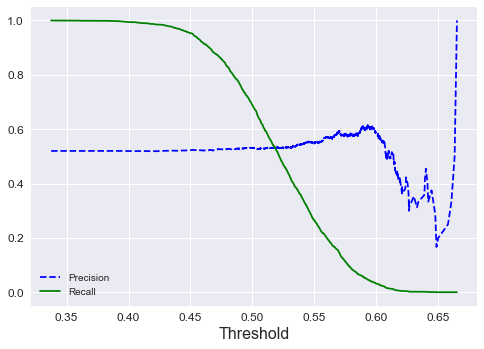

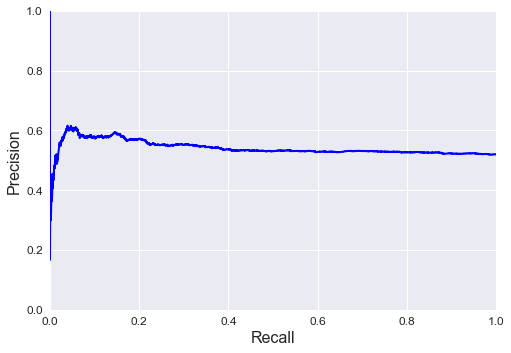

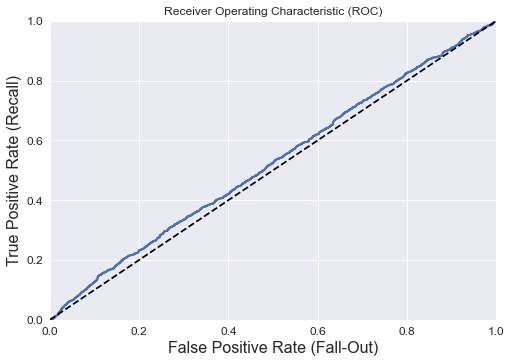

ValueError: Length of values does not match length of index

In [8]:
X = df[cols].values

score_dict = {}

for lag in range(1,5):
    
    print('Lag: {}'.format(lag))
    
    y = df['Up_y_{}'.format(lag)].values
    X_train, X_test, y_train, y_test = ufML.split_train_test_data(X, y, based_on='random', dataindex=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    lr = LogisticRegression(solver='newton-cg')
    
    scores = cross_val_score(lr, X_train_scaled, y_train, cv=10, scoring='accuracy')
        
    score_dict[lag] = scores.mean()
    print('Mean score {}'.format(scores.mean()))
    
    y_train_pred = cross_val_predict(lr, X_train_scaled, y_train, cv=10)
    conf_mx = confusion_matrix(y_train, y_train_pred)
    print(conf_mx)

    y_probas_log = cross_val_predict(lr, X_train_scaled, y_train, cv=10, method="predict_proba")
    y_scores = y_probas_log[:, 1] # Positive class probabilities

    y_train_pred = cross_val_predict(lr, X_train_scaled, y_train, cv=10)
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    
    ufML.plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    ufML.plot_precision_vs_recall(precisions, recalls)
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    ufML.plot_roc_curve(fpr, tpr)        
                
print('All scores')
print(score_dict)

In [ ]:
ufML.write2excel( df, 'df_final' )    

In [ ]:
X = df[cols].values

score_dict = {}

list_models = ['LogisticRegression']

for lag in range(1,5):
    
    print('Lag: {}'.format(lag))
    
    y = df['Up_y_{}'.format(lag)].values
    X_train, X_test, y_train, y_test = ufML.split_train_test_data(X, y, based_on='random', dataindex=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    ufML.cross_validation(list_models, X_train, y_train, scoring, cv):
    
    
    